In [1]:
# ─────────────────────────────────────────────────────────────
# Cell 1 – imports & basic setup
# ─────────────────────────────────────────────────────────────
import copy, sys, logging
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.data_handling.build_inputs import build_all
from scripts.tephra_inversion import TephraInversion
from scripts.visualization.diagnostic_plots import DiagnosticPlotter

plt.style.use("seaborn-v0_8")
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().system('tree -L 2')

.
├── README.md
├── Tephra2
│   ├── README.md
│   ├── README.usage
│   ├── common_src
│   ├── find_best_wind.pl
│   ├── forward_src
│   ├── include
│   ├── inputs
│   ├── inversion_src
│   ├── libcygwin64
│   ├── libmac
│   ├── license.md
│   ├── makefile
│   ├── plotting_scripts
│   ├── run-inversion
│   ├── tephra2-inversion_2020
│   └── tephra2_2020
├── config
│   ├── __pycache__
│   └── default_config.py
├── data
│   ├── input
│   └── output
├── example.ipynb
├── node_
├── plume2.dat
├── requirements.txt
├── scripts
│   ├── __pycache__
│   ├── core
│   ├── data_handling
│   ├── tephra_inversion.py
│   └── visualization
└── tephra_inversion.log

20 directories, 16 files


In [2]:
# ─────────────────────────────────────────────────────────────
# Cell 2 – generate the two Tephra2 input files
# ─────────────────────────────────────────────────────────────
vent_lat, vent_lon, vent_elev = 31.9, 130.9, 1000

build_all(
    vent_lat  = vent_lat,
    vent_lon  = vent_lon,
    vent_elev = vent_elev,
)

tephra2.conf written → data/input/tephra2.conf
esp_input.csv written → data/input/esp_input.csv
[INFO] Input bundle ready.


In [3]:
# ─────────────────────────────────────────────────────────────
# Cell 3 – wrap observations + sites into one DataFrame
# ─────────────────────────────────────────────────────────────
obs_vec = np.loadtxt("data/input/observations.csv")          # 1-D array

# Check the file format first
with open("data/input/sites.csv", "r") as f:
    first_line = f.readline().strip()
    
# Determine separator based on first line
if "," in first_line:
    sites_ar = pd.read_csv("data/input/sites.csv", sep=",", header=None).values
    print("Using comma separator for sites.csv")
else:
    sites_ar = pd.read_csv("data/input/sites.csv", sep=r"\s+", header=None).values
    print("Using whitespace separator for sites.csv")

obs_df = pd.DataFrame({
    "easting":      sites_ar[:, 0],
    "northing":     sites_ar[:, 1],
    "elevation":    sites_ar[:, 2],
    "observation":  obs_vec,
})

obs_df

Using whitespace separator for sites.csv


,easting,northing,elevation,observation
0,691998.0,3520374.0,1000.0,10.00
1,688621.0,3522661.0,1000.0,18.00
2,685128.0,3524972.0,1000.0,15.00
3,682997.0,3529018.0,1000.0,51.00
4,682918.0,3528234.0,1000.0,55.33
...,...,...,...,...
58,682730.0,3528208.0,1000.0,50.00
59,685508.0,3529620.0,1000.0,20.00
60,685518.0,3529780.0,1000.0,18.00
61,697972.0,3527237.0,1000.0,1.00


In [4]:
# ─────────────────────────────────────────────────────────────
# Cell 4 – build a minimal config (plume_height & ln(mass) free)
# ─────────────────────────────────────────────────────────────
esp_params = pd.read_csv("data/input/esp_input.csv")
esp_params

,variable_name,initial_val,prior_type,prior_para_a,prior_para_b,draw_scale
0,column_height,1.000000e+04,Gaussian,10000.00,2000.0,50.00
1,log_m,2.394000e+01,Gaussian,23.94,1.0,0.25
2,alpha,3.400000e+00,Fixed,NaN,NaN,NaN
3,beta,2.000000e+00,Fixed,NaN,NaN,NaN
4,gs_max,-5.000000e+00,Fixed,NaN,NaN,NaN
5,gs_min,5.000000e+00,Fixed,NaN,NaN,NaN
6,gs_med,8.700000e-01,Fixed,NaN,NaN,NaN
7,gs_sd,2.000000e+00,Fixed,NaN,NaN,NaN
8,edy_const,4.000000e-02,Fixed,NaN,NaN,NaN
9,diffu_coef,5.000000e+02,Fixed,NaN,NaN,NaN


In [5]:
# ─────────────────────────────────────────────────────────────
# Cell 5 – run the inversion
# ─────────────────────────────────────────────────────────────
inv = TephraInversion()
inv.config["mcmc"]["n_iterations"] = 2500
results = inv.run_inversion()

burnin  = inv.config["mcmc"]["n_burnin"]

2025-05-05 14:59:58,143 - root - INFO - Using whitespace separator for sites.csv
2025-05-05 14:59:58,144 - root - INFO - Loaded 63 observations automatically
2025-05-05 14:59:58,146 - root - INFO - Loaded 19 parameters from esp_input.csv
2025-05-05 14:59:58,147 - root - INFO - TephraInversion initialized
2025-05-05 14:59:58,147 - root - INFO - Using config file: data/input/tephra2.conf
2025-05-05 14:59:58,147 - root - INFO - Using sites file: data/input/sites.csv
2025-05-05 14:59:58,148 - root - INFO - Using wind file: data/input/wind.txt
2025-05-05 14:59:58,148 - root - INFO - Output will be written to: data/output/tephra2_output_mcmc.txt
2025-05-05 14:59:58,149 - root - INFO - Set executable permissions for Tephra2/tephra2_2020
2025-05-05 15:00:41,712 - root - INFO - MCMC finished: 2500 iters, accept=0.16


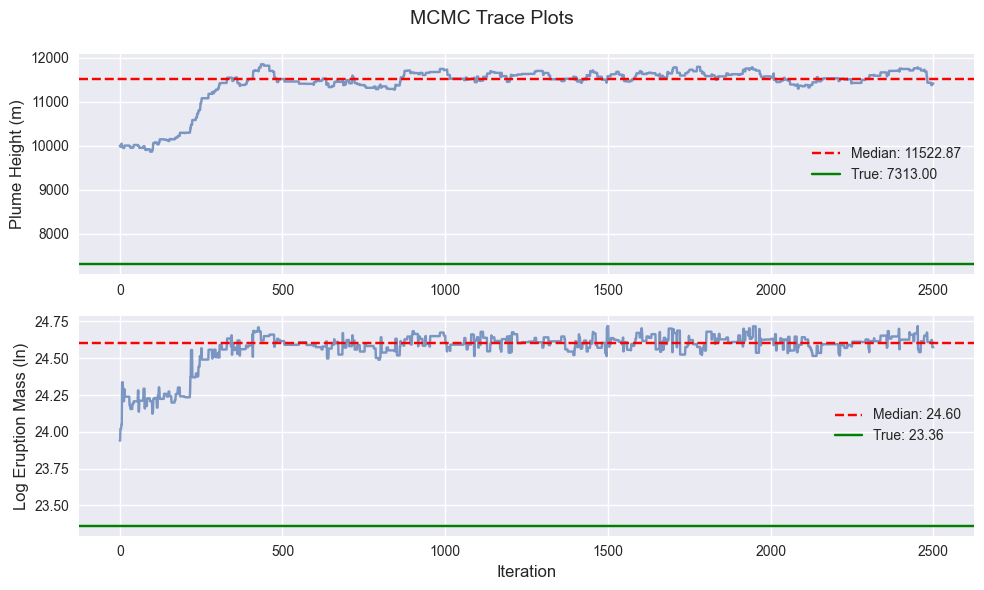


Posterior Summary Statistics:
       Parameter          Mean        Median      CI_2.5%      CI_97.5%
0  column_height  11405.469246  11522.872459  9987.895174  11760.327551
1          log_m     24.569491     24.600592    24.208170     24.683723


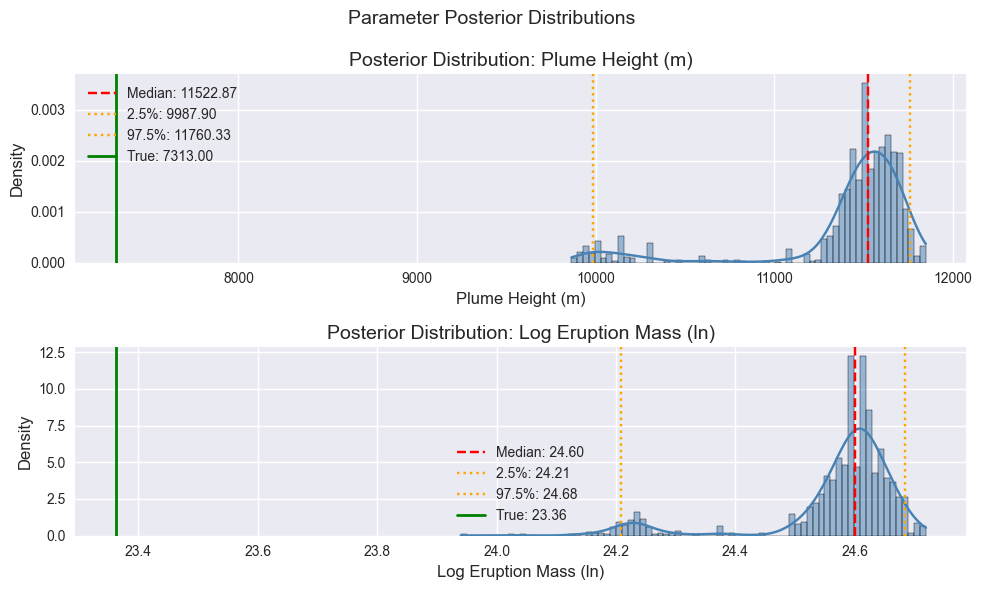

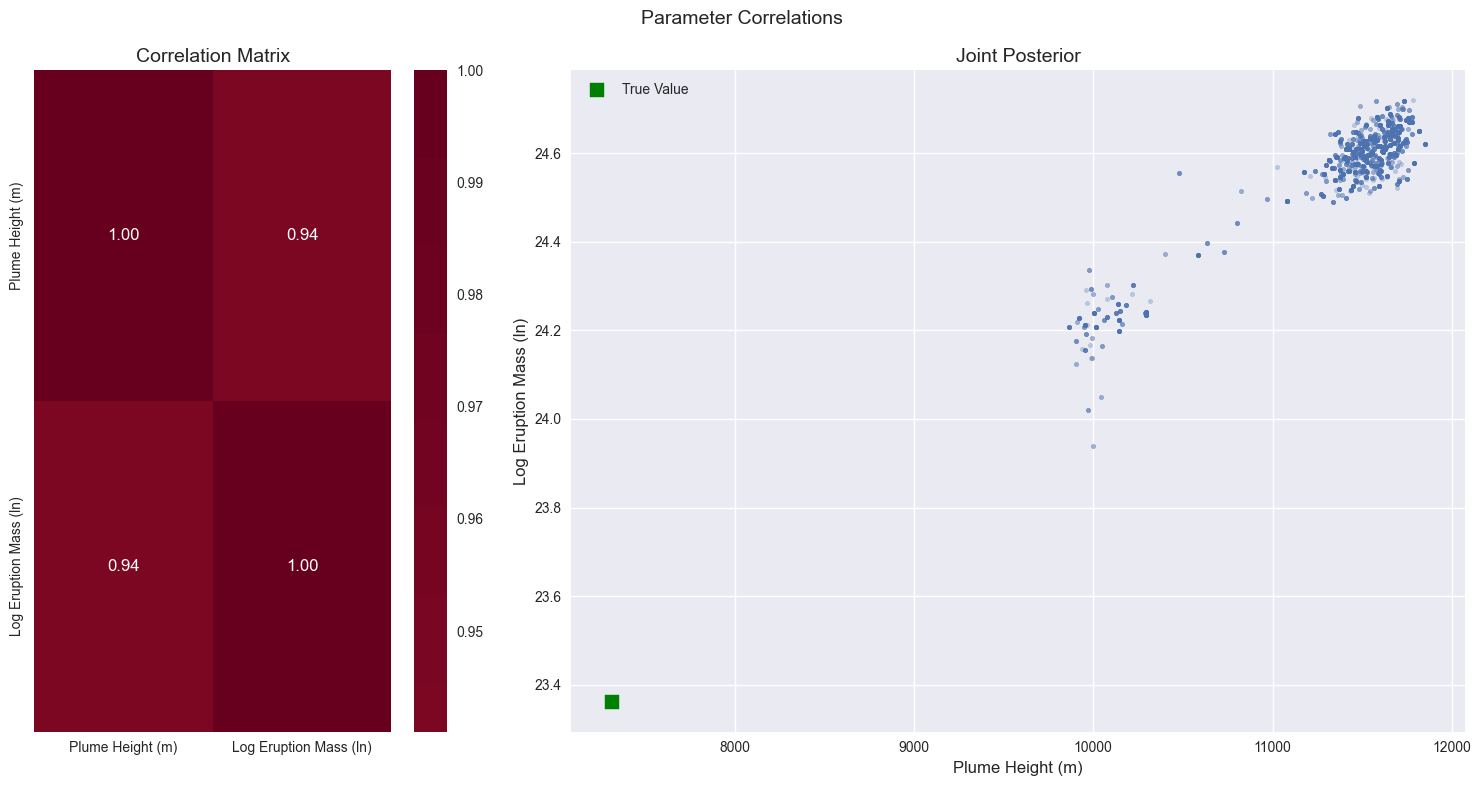

Summary saved to data/output/plots/posterior_summary.csv

Best Parameter Estimates vs. True Values:
Plume Height (m):
  Best: 11522.7129
  True: 7313.0000
Log Eruption Mass (ln):
  Best: 24.5938
  True: 23.3623


In [6]:
# Create a diagnostic plotter instance
plotter = DiagnosticPlotter(output_dir="data/output/plots")

# Convert results chain to samples dictionary
samples = {}
for param in results["chain"].columns:
    samples[param] = results["chain"][param].values

# 1. Plot trace plots for relevant parameters (those in true_values)
plotter.plot_trace(
    samples, 
    burnin=burnin,
    title="MCMC Trace Plots",
    save_path="data/output/plots/mcmc_trace.png"
)

# 2. Plot parameter posterior distributions with credible intervals and true values
plotter.plot_parameter_distributions(
    samples,
    burnin=burnin,
    title="Parameter Posterior Distributions", 
    save_path="data/output/plots/parameter_distributions.png"
)

# 3. Plot parameter correlations matrix and joint distributions
plotter.plot_parameter_correlations(
    samples,
    burnin=burnin,
    title="Parameter Correlations",
    save_path="data/output/plots/parameter_correlations.png"
)

# 4. Generate a summary table of the posterior
summary = plotter.summarize_posterior(
    samples,
    burnin=burnin,
    save_path="data/output/plots/posterior_summary.csv"
)

# Display the best parameter estimates along with true values
print("\nBest Parameter Estimates vs. True Values:")
for param in results["best_params"].index:
    if param in plotter._get_relevant_parameters(samples):
        true_val = plotter._get_true_value(param)
        if true_val is not None:
            print(f"{plotter._get_pretty_label(param)}:")
            print(f"  Best: {results['best_params'][param]:.4f}")
            print(f"  True: {true_val:.4f}")